# Benchmark comparison
This notebook compares model results across benchmark CSVs in `runs/benchmarks/`

In [85]:
import os
import glob
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 200)
sns.set_theme(style='whitegrid')


In [86]:
# Load all benchmark summary CSVs
files = sorted(glob.glob('../runs/benchmarks/summary*.csv'))
if not files:
    raise FileNotFoundError('No summary*.csv files found')

def dataset_label_from_path(path):
    name = os.path.basename(path).replace('summary_', '').replace('.csv', '')
    return name if name else 'default'

def try_parse_dict(x):
    if pd.isna(x):
        return None
    if isinstance(x, dict):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            return None
    return None

dfs = []
for f in files:
    df = pd.read_csv(f)
    df['dataset_label'] = dataset_label_from_path(f)
    dfs.append(df)

bench = pd.concat(dfs, ignore_index=True)

# Normalize numeric columns
num_cols = ['train_time_sec', 'map50', 'map50_95', 'precision', 'recall', 'f1', 'epochs', 'imgsz', 'batch']
for c in num_cols:
    if c in bench.columns:
        bench[c] = pd.to_numeric(bench[c], errors='coerce')

bench['train_time_min'] = bench.get('train_time_sec') / 60.0

# Parse per-class dicts for later use
for c in ['per_class_ap50_95', 'per_class_ap50', 'per_class_precision', 'per_class_recall', 'per_class_f1']:
    if c in bench.columns:
        bench[c] = bench[c].apply(try_parse_dict)

bench.head(10)


,model,train_time_sec,eval_split,map50,map50_95,precision,recall,f1,per_class_ap50_95,per_class_ap50,per_class_precision,per_class_recall,per_class_f1,epochs,imgsz,batch,dataset,train_results_dir,eval_results_dir,dataset_label,train_time_min
0,yolov8s.pt,103.00,val,0.822232,0.649191,0.820559,0.734548,0.775175,"{'person': 0.6543905939208481, 'bicycle': 0.26...","{'person': 0.8592708500120422, 'bicycle': 0.46...","{'person': 0.9200624683571044, 'bicycle': 1.0,...","{'person': 0.7007874015748031, 'bicycle': 0.32...","{'person': 0.7955927300207781, 'bicycle': 0.49...",50,640,16,coco128.yaml,/workspace/repo/2d-detector-benchmark/runs/det...,/workspace/repo/2d-detector-benchmark/runs/det...,coco128,1.716667
1,yolo11s.pt,125.26,val,0.842887,0.659571,0.837634,0.737062,0.784136,"{'person': 0.6444933097040136, 'bicycle': 0.45...","{'person': 0.8571956172849773, 'bicycle': 0.66...","{'person': 0.931156234663388, 'bicycle': 0.833...","{'person': 0.6922602453238966, 'bicycle': 0.33...","{'person': 0.7941307130847921, 'bicycle': 0.47...",50,640,16,coco128.yaml,/workspace/repo/2d-detector-benchmark/runs/det...,/workspace/repo/2d-detector-benchmark/runs/det...,coco128,2.087667
2,yolov8s.pt,12844.48,test,0.982143,0.820747,0.978807,0.943509,0.960834,{'person': 0.8207467114778423},{'person': 0.9821425577710095},{'person': 0.978806600259361},{'person': 0.9435089625203693},{'person': 0.9608337130490379},50,640,16,/workspace/data/fisheye-dataset/data.yaml,/workspace/repo/2d-detector-benchmark/runs/det...,/workspace/repo/2d-detector-benchmark/runs/det...,fisheye,214.074667
3,yolo11s.pt,14488.25,test,0.980800,0.819860,0.971170,0.951481,0.961225,{'person': 0.8198596184546588},{'person': 0.9807997580101535},{'person': 0.9711699888243063},{'person': 0.9514807485451451},{'person': 0.9612245531348093},50,640,16,/workspace/data/fisheye-dataset/data.yaml,/workspace/repo/2d-detector-benchmark/runs/det...,/workspace/repo/2d-detector-benchmark/runs/det...,fisheye,241.470833
4,yolov8s.pt,4406.74,test,0.990977,0.860332,0.987620,0.979716,0.983652,{'person': 0.8603319538462519},{'person': 0.9909767669044177},{'person': 0.9876202121047042},{'person': 0.9797155082454589},{'person': 0.9836519797276175},50,640,16,/workspace/data/zedrgb-dataset/data.yaml,/workspace/repo/2d-detector-benchmark/runs/det...,/workspace/repo/2d-detector-benchmark/runs/det...,zedrgb,73.445667
5,yolo11s.pt,4996.24,test,0.986841,0.864622,0.991915,0.975439,0.983608,{'person': 0.8646216911109372},{'person': 0.9868406516605376},{'person': 0.9919145834426752},{'person': 0.9754385964912281},{'person': 0.9836075992669612},50,640,16,/workspace/data/zedrgb-dataset/data.yaml,/workspace/repo/2d-detector-benchmark/runs/det...,/workspace/repo/2d-detector-benchmark/runs/det...,zedrgb,83.270667


In [87]:
# Enrich with person AP50-95 if available
bench['person_ap50_95'] = bench['per_class_ap50_95'].apply(lambda d: d.get('person') if isinstance(d, dict) else None)

In [88]:
# Overview table
cols = ['dataset_label', 'model', 'eval_split', 'map50_95', 'map50', 'precision', 'recall', 'f1', 'train_time_min']
available = [c for c in cols if c in bench.columns]
bench[available].sort_values(['dataset_label', 'map50_95'], ascending=[True, False])

,dataset_label,model,eval_split,map50_95,map50,precision,recall,f1,train_time_min
1,coco128,yolo11s.pt,val,0.659571,0.842887,0.837634,0.737062,0.784136,2.087667
0,coco128,yolov8s.pt,val,0.649191,0.822232,0.820559,0.734548,0.775175,1.716667
2,fisheye,yolov8s.pt,test,0.820747,0.982143,0.978807,0.943509,0.960834,214.074667
3,fisheye,yolo11s.pt,test,0.819860,0.980800,0.971170,0.951481,0.961225,241.470833
5,zedrgb,yolo11s.pt,test,0.864622,0.986841,0.991915,0.975439,0.983608,83.270667
4,zedrgb,yolov8s.pt,test,0.860332,0.990977,0.987620,0.979716,0.983652,73.445667


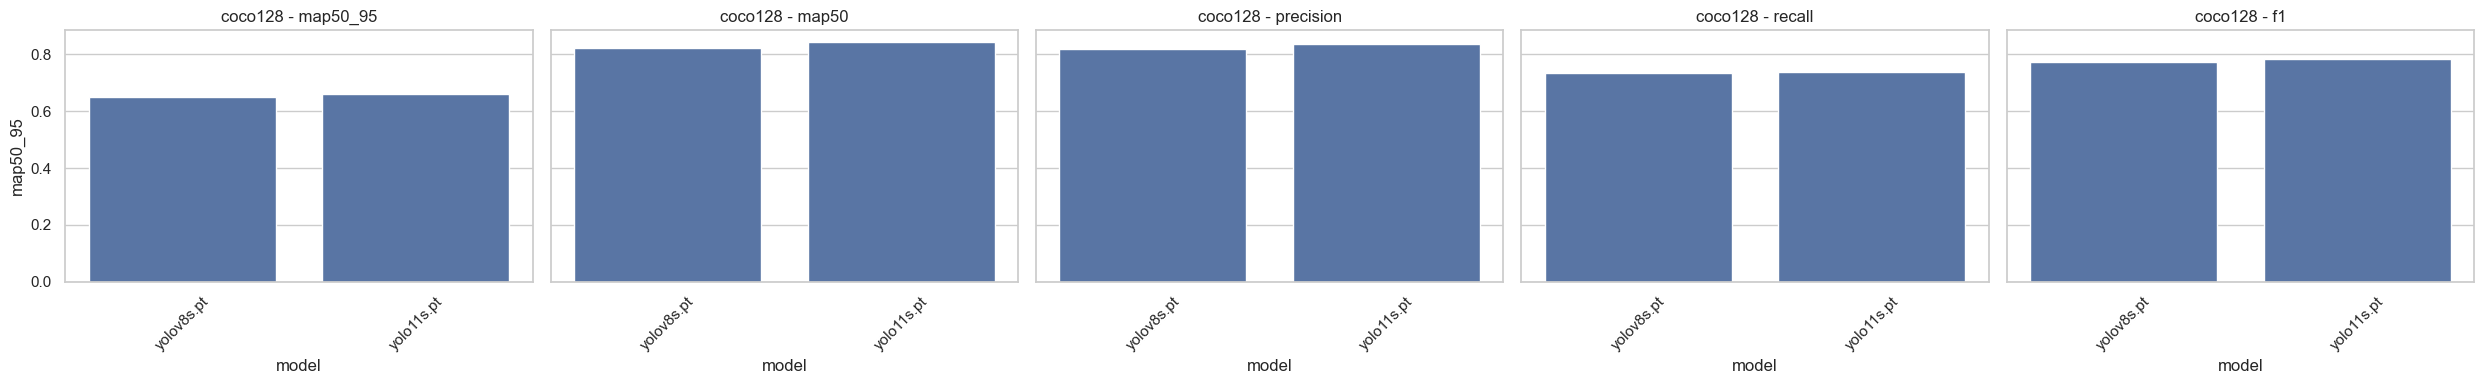

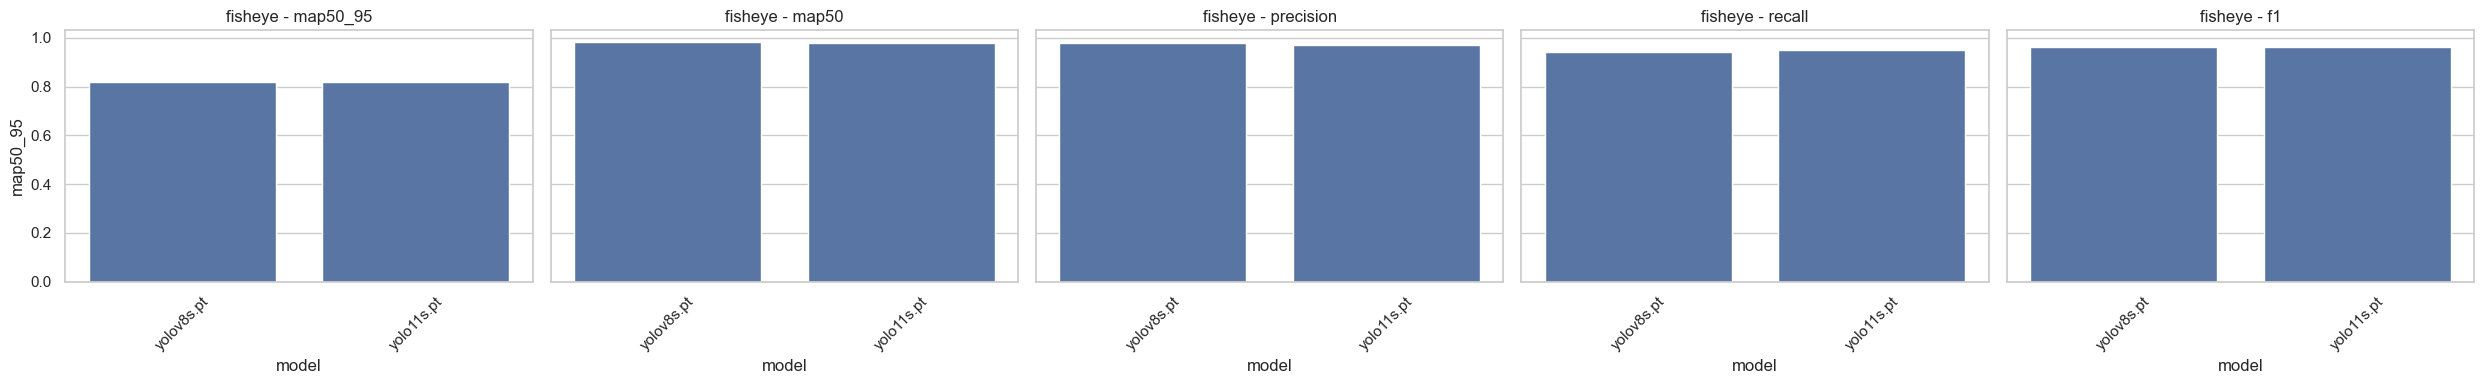

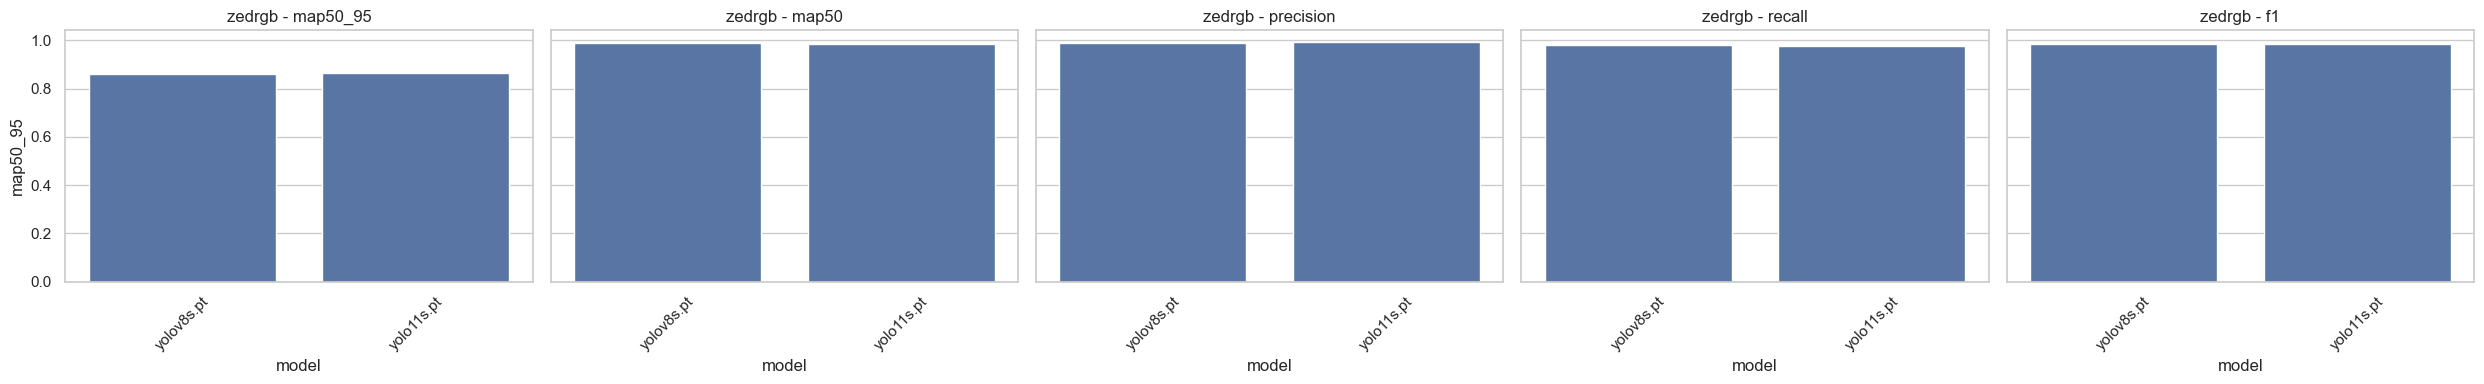

In [94]:
# Metric comparison plots per dataset
metrics = ['map50_95', 'map50', 'precision', 'recall', 'f1']
datasets = bench['dataset_label'].dropna().unique()
for ds in datasets:
    sub = bench[bench['dataset_label'] == ds]
    if sub.empty:
        continue
    fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 4), sharey=True)
    if len(metrics) == 1:
        axes = [axes]
    for ax, m in zip(axes, metrics):
        if m not in sub.columns:
            ax.axis('off')
            continue
        sns.barplot(data=sub, x='model', y=m, ax=ax)
        ax.set_title(f'{ds} - {m}')
        ax.set_xlabel('model')
        ax.set_ylabel(m)
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()


### Note: not sure if this is strictly fair to compare modes on different sized datasets

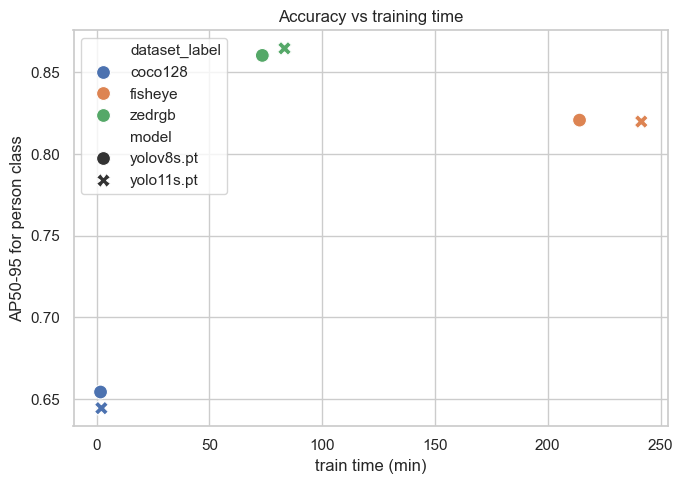

In [90]:
# Efficiency: map50_95 vs train time
if 'train_time_min' in bench.columns:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=bench, x='train_time_min', y='person_ap50_95', hue='dataset_label', style='model', s=100)
    plt.xlabel('train time (min)')
    plt.ylabel('AP50-95 for person class')
    plt.title('Accuracy vs training time')
    plt.tight_layout()
    plt.show()


In [91]:
print("AP50-95 for 'person' class in coco128 dataset:")
print(f"YOLOv8s.pt: {bench[bench['dataset_label'] == 'coco128']['per_class_ap50_95'].iloc[0]['person']}")
print(f"YOLO11s.pt: {bench[bench['dataset_label'] == 'coco128']['per_class_ap50_95'].iloc[1]['person']}")

AP50-95 for 'person' class in coco128 dataset:
YOLOv8s.pt: 0.6543905939208481
YOLO11s.pt: 0.6444933097040136


In [92]:
# Optional: per-class breakdown for a specific dataset + model
def show_top_classes(df, dataset_label, model, metric='per_class_ap50_95', top_n=10):
    sub = df[(df['dataset_label'] == dataset_label) & (df['model'] == model)]
    if sub.empty:
        print('No matching row')
        return
    d = sub.iloc[0].get(metric)
    if not isinstance(d, dict):
        print(f'No per-class dict for {metric}')
        return
    s = pd.Series(d).sort_values(ascending=False)
    display(s.head(top_n))

# Example:
show_top_classes(bench, dataset_label='coco128', model='yolov8s.pt', metric='per_class_ap50_95', top_n=10)


cup             0.995000
fork            0.995000
cake            0.995000
cell phone      0.995000
sheep           0.995000
banana          0.995000
bench           0.921494
fire hydrant    0.921129
orange          0.902238
sandwich        0.902101
dtype: float64